<a href="https://colab.research.google.com/github/salma71/blog_post/blob/master/Evaluate_ML_algos_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will compare the performance of using different methods to evaluate the performance of a machine learning algorithm. 

The methods that would be used are: 
1. Split train-test
2. k-fold cross validation
3. Leave one out cross validation
4. Repeated randome test splits



# 1.1 split into train test 



In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"salmaeng","key":"231d5b452cf64da4dc6c6ff6eb15b34a"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:

#Make directory named kaggle and copy kaggle.json file there.
#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#unzip the folder
!mkdir train
!unzip pima-indians-diabetes-database.zip -d train

mkdir: cannot create directory ‘train’: File exists
Archive:  pima-indians-diabetes-database.zip
replace train/diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/diabetes.csv      


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [8]:
# load the data
data = pd.read_csv('/content/train/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
data.shape

(768, 9)

In [10]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [11]:
# split into train and test
1yarray = data.values

In [12]:
X = data.iloc[:, :-1].values
X.shape

(768, 8)

In [13]:
y = data.iloc[:, -1].values
y.shape

(768,)

In [14]:
seed = 7
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33,
    stratify = y,
    random_state = 7
)


In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
result = model.score(x_test, y_test)
print(f'accuracy is: {result*100.0: 0.3f}')

accuracy is:  76.378


In [16]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 2 K-fold cross validation 


In [17]:
from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold


In [18]:
kfold = KFold(n_splits = 10, random_state = 7)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [19]:
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv=kfold)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.776 (0.052)


We got a better accuracy with the kfold cross validation. Now, I want to investigate to see the distribution of the accuracy for each fold.
I will make use of the `RepeatedFold()` class with the `sklearn` package

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt

cv_repeated = RepeatedStratifiedKFold(
    n_splits = 10,
    n_repeats = 16,
    random_state = seed
)

In [21]:
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv=cv_repeated)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.775 (0.042)


In [22]:
# define a function to evaluate a model with a given number of repeats
def asses_model(X, y, repeats):
  # define the cv folds 
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state = seed)
  # create the model 
  model = LogisticRegression(max_iter=1000)
  # evaluate model 
  scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs=-1)
  return scores

Calculate standard error for a sample using `sem()` within `scipy` package

In [23]:
repeats = range(1, 16)
res = list()
for rep in repeats:
  scores = asses_model(X, y, rep)
  print('Sample_%d mean=%.4f se=%.3f' % (rep, np.mean(scores), sem(scores)))
  res.append(scores)

Sample_1 mean=0.7761 se=0.011
Sample_2 mean=0.7780 se=0.009
Sample_3 mean=0.7774 se=0.007
Sample_4 mean=0.7767 se=0.007
Sample_5 mean=0.7761 se=0.006
Sample_6 mean=0.7754 se=0.005
Sample_7 mean=0.7749 se=0.005
Sample_8 mean=0.7757 se=0.004
Sample_9 mean=0.7755 se=0.004
Sample_10 mean=0.7755 se=0.004
Sample_11 mean=0.7751 se=0.004
Sample_12 mean=0.7751 se=0.004
Sample_13 mean=0.7751 se=0.004
Sample_14 mean=0.7751 se=0.004
Sample_15 mean=0.7752 se=0.003


Looking at the standard error, we can see that it decreases with an increase in the number of repeats and stabilizes with a value around 0.004 at around 9 or 10 repeats.

In [24]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<function matplotlib.pyplot.show>

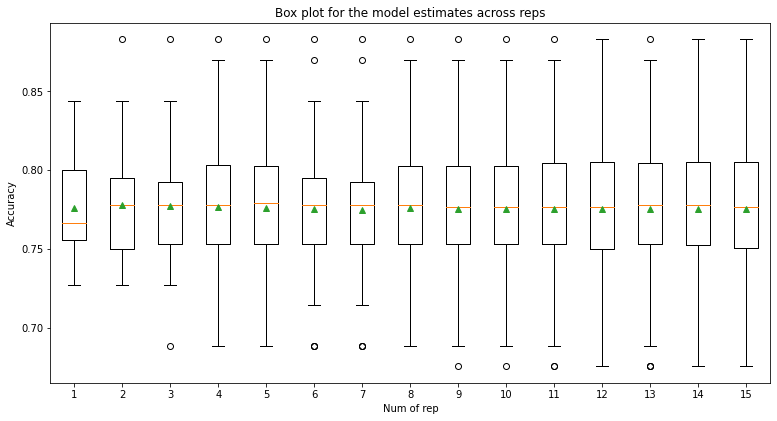

In [25]:
# plot thsose results to compare
fig = plt.figure()
fig.set_size_inches(10.0, 5.0)
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.set_xlabel('Num of rep')   
ax.set_ylabel('Accuracy')
ax.set_title('Box plot for the model estimates across reps')     
ax.boxplot(res, labels=[str(rep) for rep in repeats], showmeans=True)
plt.show

The orange line represents the median of the distribution. However the grean triangle indicates the arthmetic mean.

From the graph above, we may consider a number of folds to harness. Eight(8) folds seems to be a good choice with average accuracy of 77.40%. 

It didn't perform than the normal kFold validation!

Shuffle got a less accuracy with the same number of splits!

# 5. Leave One Out Cross Validation


In [26]:
X.shape[0]
y.shape

(768,)

In [27]:
from sklearn.model_selection import LeaveOneOut
loocv = LeaveOneOut()
model = LogisticRegression(max_iter=1000)
res = cross_val_score(model, X, y, cv = X.shape[0])
print('Accuracy: %.3f (%.3f)' % (np.mean(res), np.std(res)))

Accuracy: 0.776 (0.417)


A little better than what we did in the previous sections.

# Need to be vigilent
- LOOCV is computationally expensive, so don't use with large dataset otherwise it might overfit. 
- Use only with small dataset or when the performance of an estimated model is critical.

> LOOCV is appropriate when an acurate estimate of model performance is critical. Such case when the dataset is small (less than thousands of examples) can lead to model overfitting during the training and as a consequences a baised estimates of model performance.

> Also , this estimation procedure is determinestic  because there is no sampling of the training dataset. Unlike the regular train test split and kfold Cv which is stochastic estimate of the model performance.

- Don't use it with models that care costly to fit such as neural networks.

> note that, for Regression MAE (negatice_mean_absolute_error) is more appropriate scoring metric inside the `cross_val_score()` methods.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


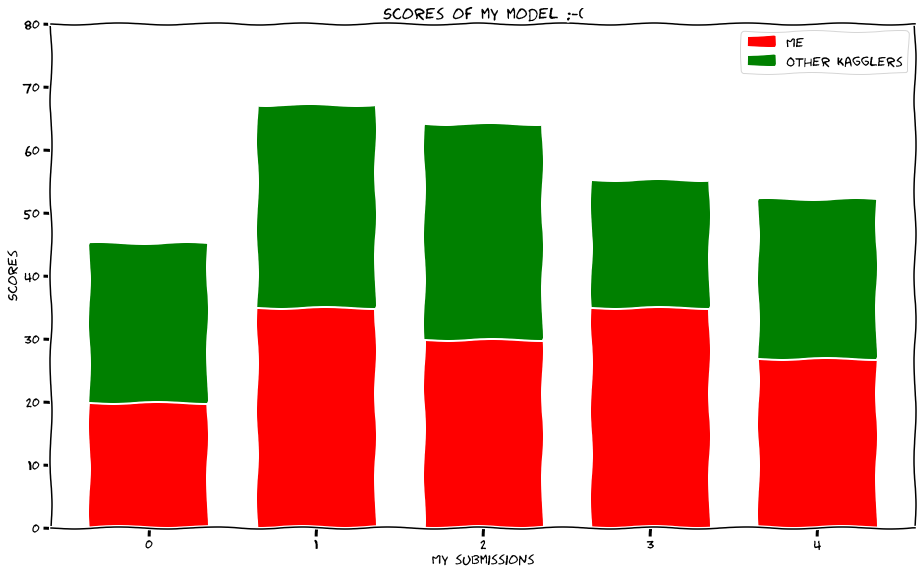

In [28]:
# generate the cover image with matlibplot
with plt.xkcd():
  N = 5
  me = (20, 35, 30, 35, 27)
  others = (25, 32, 34, 20, 25)
  ind = np.arange(N) # the x locations for the groups
  width = 0.7
  fig = plt.figure()
  fig.set_size_inches(12.0, 7.0)
  ax = fig.add_axes([0,0,1,1])
  ax.bar(ind, me, width, color='r')
  ax.bar(ind, others, width,bottom=me, color='g')
  ax.set_ylabel('Scores')
  ax.set_title(u'Scores of my model :-(')
  ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
  ax.set_xlabel('My submissions')
  ax.set_yticks(np.arange(0, 81, 10))
  ax.legend(labels=['Me', 'Other kagglers'])
plt.show()

[]

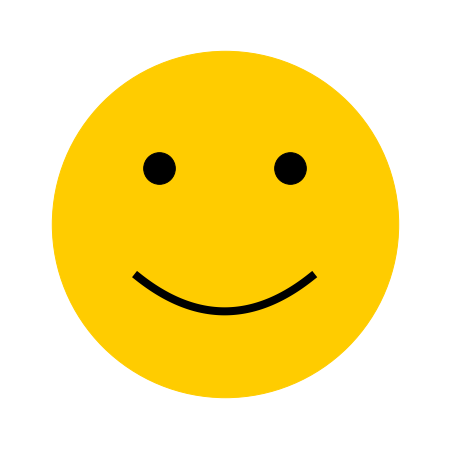

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, aspect=1)

ax.scatter([.5],[.5], c='#FFCC00', s=120000, label="face")
ax.scatter([.35, .65], [.63, .63], c='k', s=1000, label="eyes")

X = np.linspace(.3, .7, 100)
Y = 2* (X-.5)**2 + 0.30

ax.plot(X, Y, c='k', linewidth=8, label="smile")

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Which one to choose?

Each procedure has pros and cons; however, there are some tips we might consider when choosing a procedure. 

1. k-fold cv is the rule of thumb rule for assessing the performance of an algorithm for unseen data, with set k to 3, 5, or 10 (most common used folds)

2. Train test split is a good starting point to investigate the preliminary performance of a specific algorithm. It is fast and can give an idea of which algorithm to pick.

3. LOOCV and repeated random split might be beneficial when trying to balance variance in the estimated performance, model training and dataset size. 



# Improve performance using ensambles

Ensambles could boost the accuracy of the machine learning model.